SVI guide. Run trace. Collect zs. Plot zs against thickness, intensity.

for do(i = 300) what are the values in the output image. Obvs cannot be more than 256.

In [1]:
ROOT_PATH = '../../../../'
# MNIST_DATA_PATH = ROOT_PATH + 'assets/data/morphomnist_reversed_pgm/'
# BASE_LOG_PATH = ROOT_PATH + 'assets/models/morphomnist_reversed_pgm/'

import sys
import os
import inspect
from collections import OrderedDict
from functools import partial

sys.path.append(ROOT_PATH)

import pyro
import torch
import torch.nn.functional as F
import torch_geometric.nn as gnn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
from torch_cluster import grid_cluster

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
%matplotlib inline

## Setup and Data Inspection

In [4]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    
def prep_single_image(batch):
    x = batch['image']
    thickness = batch['thickness'].unsqueeze(0).unsqueeze(0).float()
    intensity = batch['intensity'].unsqueeze(0).unsqueeze(0).float()

    x = x.float()
    x = x.unsqueeze(0).unsqueeze(0)

    return {'x': x, 'thickness': thickness, 'intensity': intensity}

def prep_batch(batch):
    x = batch['image']
    thickness = batch['thickness'].unsqueeze(1).float()
    intensity = batch['intensity'].unsqueeze(1).float()
    x = x.float().unsqueeze(1)
    return {'x': x, 'thickness': thickness, 'intensity': intensity}


class LayerActivations:
    
    def __init__(self, name):
        self.activation = {}
        self.name = name
        
    def __call__(self, model, _input, output):
        self.activation[self.name] = output.detach()
        
    def get_activation(self):
        return self.activation

In [5]:
from torch_geometric.datasets import MNISTSuperpixels
from torchvision.datasets import MNIST

graph_train_dataset = MNISTSuperpixels(root='./MNIST/graphs/', train=True)
image_train_dataset = MNIST(root='.', train=True)

In [6]:
graph_train_dataset[2]

Data(edge_index=[2, 1384], pos=[75, 2], x=[75, 1], y=[1])

In [7]:
scale = 32
rescale = 4
offset = torch.FloatTensor([1, 1])
idx = 2

image, _ = image_train_dataset[idx]
image = np.array(image)
data = graph_train_dataset[idx]

In [8]:
import torch_geometric.transforms as T

cart = T.Cartesian()
tst = T.ToSparseTensor(remove_edge_index=False)
undir = T.ToUndirected()

In [9]:
data = cart(graph_train_dataset[0].to(device))
data = tst(data)
data = undir(data)
data.batch = None
data

/vol/bitbucket/rrr2417/deepscm/ENV2/lib/python3.8/site-packages/torch_sparse/tensor.py:290: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  ptr = mask.nonzero().flatten()


Data(adj_t=[75, 75, 2, nnz=1399], edge_attr=[1399, 2], edge_index=[2, 1399], pos=[75, 2], x=[75, 1], y=[1])

In [10]:
data.edge_attr, data.edge_index.shape

(tensor([[0.7829, 0.5218],
         [0.9643, 0.3839],
         [0.6378, 0.4927],
         ...,
         [0.1581, 0.6372],
         [0.1634, 0.4129],
         [0.6277, 0.3839]], device='cuda:0'),
 torch.Size([2, 1399]))

In [11]:
from torch_geometric.nn.pool.consecutive import consecutive_cluster
from torch_geometric.nn.pool import max_pool, max_pool_x

size = 3
grid_size = data.pos.new(2).fill_(size)
cluster = grid_cluster(data.pos, grid_size).contiguous()
pooled_data = max_pool(cluster, data)

pooled_img, index, position = pooled_data['x'], pooled_data['edge_index'], pooled_data['pos']
n = pooled_data['pos'].size(0)

In [12]:
pooled_img.shape, index.shape, position.shape, n 

(torch.Size([66, 1]), torch.Size([2, 1064]), torch.Size([66, 2]), 66)

In [13]:
offset = torch.FloatTensor([(28 - position[:, 0].max()) / 2,
                            (28 - position[:, 1].max()) / 2])

In [14]:
position *= (scale * offset).to(device)
position += (scale * offset * rescale).to(device)

In [15]:
from skimage.color import gray2rgb
from PIL import Image, ImageDraw

In [16]:
image = np.ones((28, 28), np.uint8)
image = np.repeat(image, scale * rescale, axis=0)
image = np.repeat(image, scale * rescale, axis=1)
image = gray2rgb(image, alpha=True)
image *= np.array([255, 255, 255, 1], np.uint8)
image = Image.fromarray(image)
draw = ImageDraw.Draw(image)

<ipython-input-16-5bf2aee1e172>:4: FutureWarning: alpha argument is deprecated and will be removed in version 0.19. Please use the gray2rgba function insteadto obtain an RGBA image.
  image = gray2rgb(image, alpha=True)


In [17]:
adj = torch.sparse_coo_tensor(index, torch.ones(index.size(1)).to(device), [n, n])
index = adj._indices().t()

for i in range(index.size(0)):
    start, end = index[i]
    start_x, start_y = position[start]
    end_x, end_y = position[end]
    start_x, start_y = int(start_x), int(start_y)
    end_x, end_y = int(end_x), int(end_y)

    draw.line(
        (start_x, start_y, end_x, end_y),
        fill=(0, 0, 0, 255),
        width=rescale * 2)

In [18]:
for i in range(n):
    x, y = position[i]
    r = 16 * rescale
    draw.ellipse((x - r, y - r, x + r, y + r), fill=(0, 0, 0, 255))
    r = 14 * rescale
    draw.ellipse(
        (x - r, y - r, x + r, y + r), fill=(49, 130, 219, int(255 * pooled_img[i]))
    )

image = image.resize((28 * scale, 28 * scale), Image.ANTIALIAS)

# image.show()

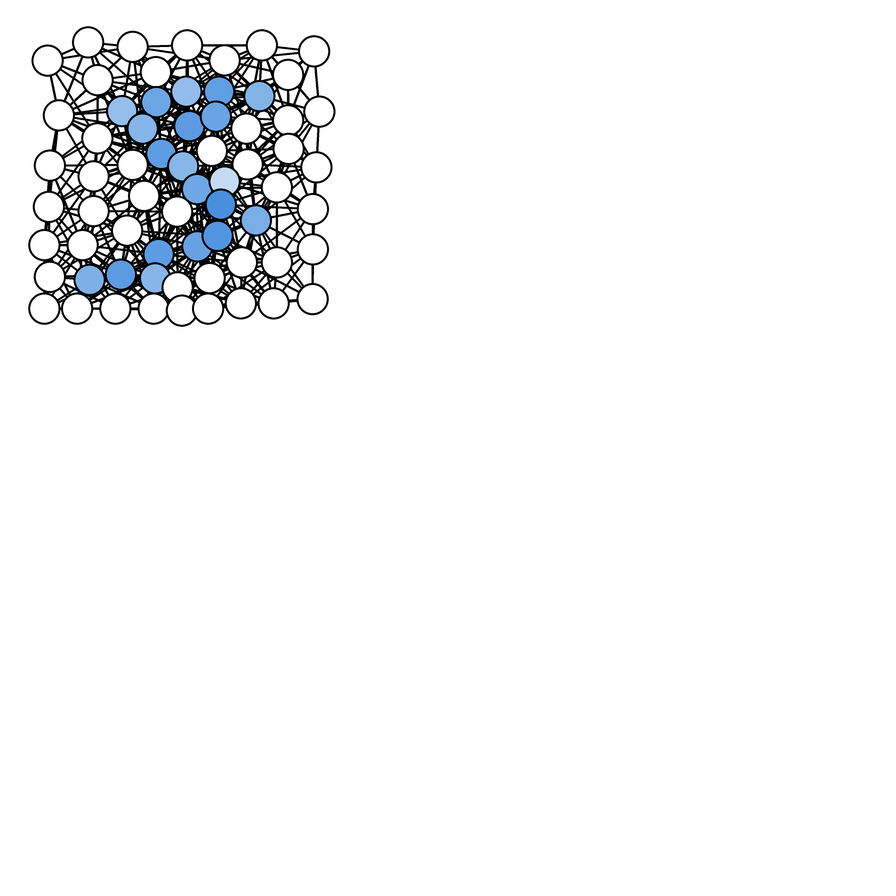

In [19]:
image

## Classifier Model

In [20]:
class Net(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(Net, self).__init__()
        self.conv1 = gnn.GCNConv(num_node_features, 16)
        self.conv2 = gnn.GCNConv(16, num_classes)

    def forward(self, data):
        """
        Implementation from Kipf and Welling GCN
        """
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = F.dropout(x, training=self.training)
        x = F.relu(x)
        
        x = self.conv2(x, edge_index)
        x = F.dropout(x, training=self.training)

        return F.log_softmax(x, dim=1)

In [192]:
from torch_geometric.data import Data


class SplineCNN(torch.nn.Module):
    def __init__(self):
        super(SplineCNN, self).__init__()
        self.conv1 = gnn.SplineConv(1, 32, dim=2, kernel_size=5)
        self.conv2 = gnn.SplineConv(32, 64, dim=2, kernel_size=5)
        self.fc1 = torch.nn.Linear(64, 128)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        cluster = gnn.graclus(edge_index, num_nodes=x.size(0))
        data = Data(x, edge_index, edge_attr)
        data.batch = None
        data = gnn.max_pool(cluster, data)
        
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        x = F.elu(self.conv2(x, edge_index, edge_attr))
        cluster = gnn.graclus(edge_index, num_nodes=x.size(0))
        data = Data(x, edge_index, edge_attr)
        data.batch = None
        data = gnn.max_pool(cluster, data)
        
        # print(data.x.shape, data.x.size(0))
        
        x = gnn.global_mean_pool(data.x, torch.zeros((data.x.size(0))).long().to(device))
        x = F.elu(self.fc1(x))
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

In [193]:
cart = T.Cartesian()
tst = T.ToSparseTensor(remove_edge_index=False)
undir = T.ToUndirected()

In [194]:
spline_cnn = SplineCNN().to(device)

_data = cart(graph_train_dataset[0].to(device))
_data = tst(_data)
_data = undir(_data)

# spline_cnn(_data)

In [195]:
# _data.batch = 1

In [196]:
# torch.zeros((data.x.size(0))).long()

In [197]:
spline_cnn(_data)

tensor([[-2.3487, -2.3491, -2.3167, -2.3744, -2.1471, -2.2856, -2.2747, -2.2826,
         -2.2665, -2.4042]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)

In [182]:
# from torch_geometric.data import DataLoader

# batch_size = 32
# graph_train_loader = DataLoader(graph_train_dataset, batch_size=batch_size, shuffle=True)

In [183]:
num_node_features = graph_train_dataset.num_node_features
num_classes = graph_train_dataset.num_classes

In [184]:
len(graph_train_dataset)

60000

In [199]:
# model = Net(num_node_features, num_classes).to(device)
model = SplineCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [200]:
model.train()

# for epoch in range(2):
#     for batch in graph_train_loader:
#         optimizer.zero_grad()
#         # print(batch)
#         # print(batch.batch)
#         out = model(batch.to(device))
#         # print(out.shape)
#         print(out.shape, batch.y.shape)
#         loss = F.nll_loss(out, batch.y)
#         loss.backward()
#         optimizer.step()

# print(graph_train_dataset.x)

for epoch in range(1):
    for i in range(len(graph_train_dataset)):
        if i % 10000 == 0:
            print(i)
        optimizer.zero_grad()
        
        # preprocessing
        data = cart(graph_train_dataset[i].to(device))
        data = tst(data)
        data = undir(data)
        
        # print(data)
        
        out = model(data)  # graph_train_dataset[i].to(device))
        # print(out)
        loss = F.nll_loss(out, graph_train_dataset[i].y.to(device))
        # loss = F.nll_loss(out, graph_train_dataset[i].y.repeat(75).to(device))
        loss.backward()
        optimizer.step()

0
10000
20000
30000
40000
50000


In [201]:
graph_test_dataset = MNISTSuperpixels(root='./MNIST/graphs', train=False)
graph_test_dataset

MNISTSuperpixels(10000)

In [202]:
graph_test_loader = DataLoader(graph_test_dataset, batch_size=len(graph_test_dataset), shuffle=True)

In [207]:
total_acc = 0

model.eval()

n = len(graph_test_dataset)

for i in range(n):
    # preprocessing
    data = cart(graph_test_dataset[i].to(device))
    data = tst(data)
    data = undir(data)
    
    _, pred = model(data).max(dim=1)
    correct = pred.eq(graph_test_dataset[i].y.to(device)).item()
    # print(correct)
    acc = correct  # / 75
    total_acc += acc
    # print(total_acc)

print('Accuracy:', total_acc / n)

Accuracy: 0.3477
